In [99]:
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split

In [27]:
df_all = pd.read_csv("train.csv")
print(df_all.info())
print(df_all.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   LifeTime             10001 non-null  float64
 1   FlightDistance       10001 non-null  float64
 2   FlightDistanceError  10001 non-null  float64
 3   IP                   10001 non-null  float64
 4   VertexChi2           10001 non-null  float64
 5   pt                   10001 non-null  float64
 6   DOCAone              10001 non-null  float64
 7   DOCAtwo              10001 non-null  float64
 8   DOCAthree            10001 non-null  float64
 9   IP_p0p2              10001 non-null  float64
 10  IP_p1p2              10001 non-null  float64
 11  isolationa           10001 non-null  int64  
 12  isolationb           10001 non-null  int64  
 13  isolationc           10001 non-null  int64  
 14  CDF1                 10001 non-null  float64
 15  CDF2                 10001 non-null 

In [21]:
df_signal = df_all[df_all['signal'] == 1]
df_background = df_all[df_all['signal'] == 0]
#print(df_signal['signal'].head(20))
#print(df_background['signal'].head(20))

In [24]:
ks_2samp?

Signature: ks_2samp(data1, data2, alternative='two-sided', mode='auto')
Docstring:
Compute the Kolmogorov-Smirnov statistic on 2 samples.

This is a two-sided test for the null hypothesis that 2 independent samples
are drawn from the same continuous distribution.  The alternative hypothesis
can be either 'two-sided' (default), 'less' or 'greater'.

Parameters
----------
data1, data2 : array_like, 1-Dimensional
    Two arrays of sample observations assumed to be drawn from a continuous
    distribution, sample sizes can be different.
alternative : {'two-sided', 'less', 'greater'}, optional
    Defines the alternative hypothesis.
    The following options are available (default is 'two-sided'):

      * 'two-sided'
      * 'less': one-sided, see explanation in Notes
      * 'greater': one-sided, see explanation in Notes
mode : {'auto', 'exact', 'asymp'}, optional
    Defines the method used for calculating the p-value.
    The following options are available (default is 'auto'):

      *

In [92]:
tag_list = list(df_all.columns.values)
tag_list.remove('signal')
vals = []
for tag in tag_list:
    v = ks_2samp(df_signal[tag], df_background[tag])
    if tag == 'IP':
        pass#print(v)
    vals.append(list(v)+[tag])
vals.sort()
for v in vals:
    print(v)
#X = np.array(vals)
#plt.plot(X[:,0])

[0.01947211509327388, 0.32901147180710355, 'p2_p']
[0.024049263408896224, 0.12892519322184193, 'p2_IP']
[0.030658834247363074, 0.023393817729546185, 'p1_IP']
[0.03251561479282918, 0.013448963630375732, 'p0_p']
[0.04127888273339044, 0.0006363734032619472, 'p1_p']
[0.04399070644801593, 0.00021380395190706558, 'p2_IPSig']
[0.04459189340011242, 0.00016630989516475125, 'p2_pt']
[0.05648135049467106, 5.745821030078702e-07, 'p0_eta']
[0.06444300749394435, 6.124802887086389e-09, 'FlightDistanceError']
[0.06492223974296761, 4.5716822549835e-09, 'p1_IPSig']
[0.064954970701966, 4.480768756032205e-09, 'p2_eta']
[0.06595768575626879, 2.412261834727758e-09, 'p1_eta']
[0.06646369788083618, 1.7584104172740922e-09, 'IP_p0p2']
[0.08541284026169804, 2.55351295663786e-15, 'p0_pt']
[0.09048834930887517, 3.296496054422018e-17, 'CDF1']
[0.10359110479653925, 1.984325413365685e-22, 'FlightDistance']
[0.1267091936758006, 2.237177537627148e-33, 'p1_pt']
[0.12941264336585118, 8.39554348092537e-35, 'DOCAthree']
[0

<Figure size 432x288 with 0 Axes>

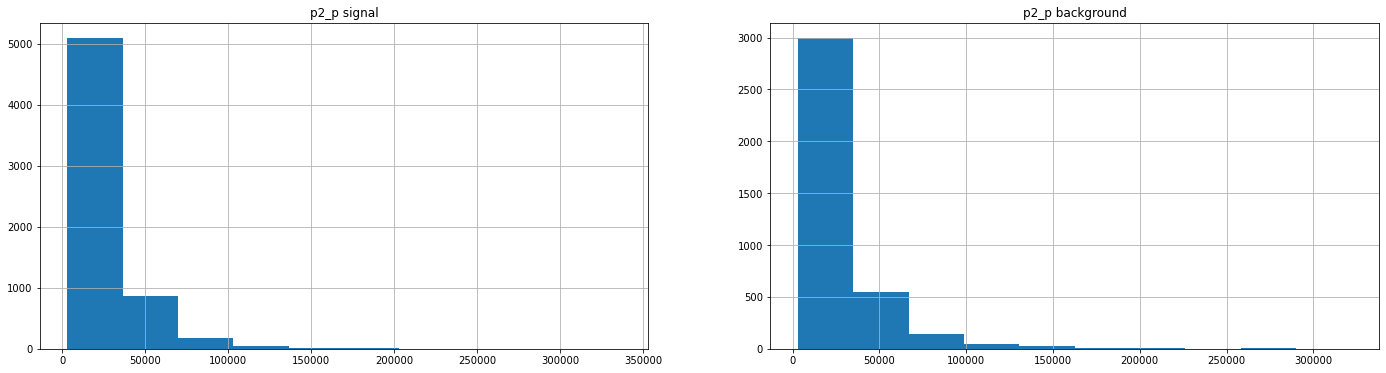

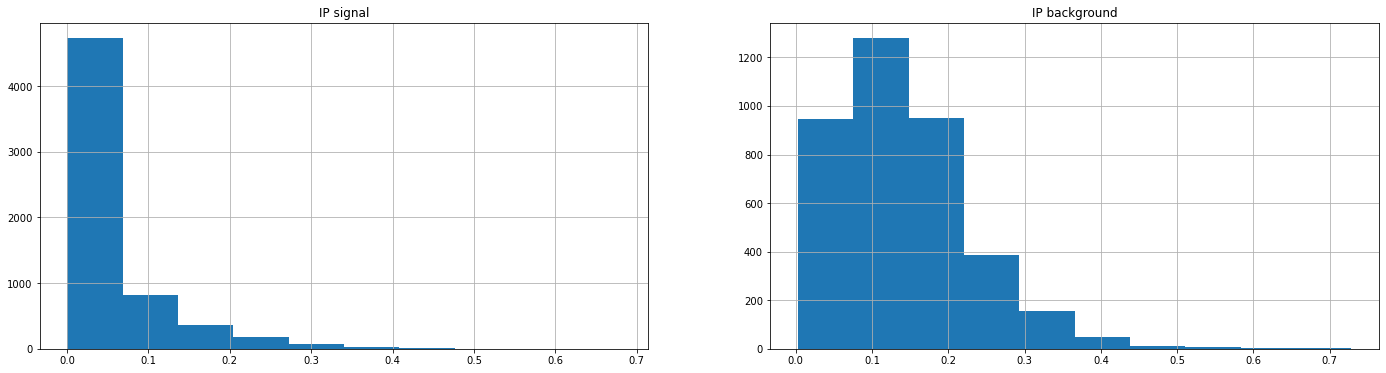

In [86]:
%matplotlib inline

"""
num= 2
fig, ax = plt.subplots(num,2,figsize=(24,6*num))
for i in range(num):
    ax[i, 0].hist(df_signal[vals[i][2]])
    ax[i, 0].set_title(vals[i][2]+ " signal")
    ax[i, 0].grid()

    ax[i, 1].hist(df_background[vals[i][2]])
    ax[i, 1].set_title(vals[i][2]+ " background")
    ax[i, 1].grid()

plt.show()
"""
plt.figure(0)
fig, ax = plt.subplots(1,2,figsize=(24,6))
ax[0].hist(df_signal[vals[0][2]])
ax[0].set_title(vals[0][2]+ " signal")
ax[0].grid()
ax[1].hist(df_background[vals[0][2]])
ax[1].set_title(vals[0][2]+ " background")
ax[1].grid()

plt.figure(1)
fig, ax = plt.subplots(1,2,figsize=(24,6))
ax[0].hist(df_signal[vals[-1][2]])
ax[0].set_title(vals[-1][2]+ " signal")
ax[0].grid()
ax[1].hist(df_background[vals[-1][2]])
ax[1].set_title(vals[-1][2]+ " background")
ax[1].grid()

In [97]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

def fitBDT(df, cols, tag, ntrees= 500, ndepth= 15):
    """
    Fits a boosted decision tree to cols of df to reproduce tag of df
    
    Parameters:
    -----------
    df: Pandas Dataframe containing all data required for fitting

    cols: a list of strings, describing the input columns with which to fir the BDT

    tag: a string describing the column for which to fit 

    ntrees: integer, depth of the AdaBoostRegressor

    ndepth: integer, depth of the DecisionTreeRegressor

    Returns:
    --------
    AdaBoostRegressor
    """
    BDT = AdaBoostRegressor(n_estimators=ntrees, base_estimator=DecisionTreeRegressor(max_depth=ndepth))
    BDT.fit(df[cols], df[tag])
    return BDT


In [111]:
tag_list = list(np.array(vals)[:15,2])
goal = 'signal'

df_train, df_test = train_test_split(df_all, test_size=0.5)
BDT = fitBDT(df_train, tag_list, goal, ntrees= 1000, ndepth= 30)

In [112]:
df_test['predicted_sig'] = BDT.predict(df_test[tag_list])
print(df_test[tag_list + ['signal', 'predicted_sig']].head(20))
df_test['diff'] = (df_test['predicted_sig'] - df_test['signal'])
variation = df_test['diff'].abs().mean()
print(variation)

              p2_p     p2_IP     p1_IP          p0_p          p1_p   p2_IPSig  \
6847   6958.560547  0.757248  0.323618   3658.381348  12487.100586  41.309967   
3582  22875.314453  0.856820  0.127643  46856.937500  49276.300781  48.022625   
2359   7281.197266  0.216823  0.315506  10104.791016   9076.125977   7.431485   
9102   5240.011230  0.562401  0.106240   6667.981934  23972.841797  18.785133   
1825  15868.359375  0.240078  0.091317  23173.722656  27656.806641   7.028679   
1180   8360.746094  0.297302  0.135719   7520.580078  78495.656250   3.576519   
842    8402.631836  0.265569  0.212276   3425.120361  12400.750977  13.527665   
3745  30983.292969  0.204204  0.335317  14492.704102  19540.464844   7.591322   
6300  10576.162109  0.577639  0.354974   6347.785156   4851.438477  38.757290   
7787  10888.318359  0.697900  0.405957  28277.070312  61561.394531   7.761134   
9614   8569.926758  0.257384  0.165353  18534.345703  58040.238281   6.857411   
5215  11942.688477  0.232146